In [1]:
#TASKS LEFT:  
#ADJUST GVF 
#CAPTURE CURVATURE AND OTHER METRICS 
#CREATE TRAINING AND TESTING DATA
#UNSUPERVISED LEARNING BASED ON WHAT? SUPERVISED LEARNING?
#TEST CLASSIFIER
#MAKE SLIDES
#Present
#Finish paper 

In [202]:
#Import models
import pandas as pd 
import math 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from scipy.interpolate import interp2d, RectBivariateSpline
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.util import img_as_float
from skimage._shared.utils import _supported_float_type
from skimage.filters import gaussian, sobel
from skimage.segmentation import active_contour, chan_vese, morphological_geodesic_active_contour
#from skimage.segmentation import geodesic_active_contour 
import cv2
import os 
import re
from scipy.ndimage import gaussian_filter

In [203]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

In [204]:
def my_del2(A):
    D1, D2 = A.shape
    U = np.vstack((np.zeros((1, D2)), A[:-1, :]))
    D = np.vstack((A[1:, :], np.zeros((1, D2))))
    L = np.hstack((np.zeros((D1, 1)), A[:, :-1]))
    R = np.hstack((A[:, 1:], np.zeros((D1, 1))))
    B = U + D + L + R - 4 * A
    return B

In [205]:
def calc_marr_external_energy(img, ksize = 3):
    h = gaussian_filter(img, 3)
    img_blur = h / np.max(h)
    Xf, Yf = np.gradient(img_blur)
    Fx, Fy = np.gradient(np.sqrt(Xf**2 + Yf**2))
    Fmax = np.max(np.abs(np.sqrt(Fx**2 + Fy**2)))
    Fx /= Fmax
    Fy /= Fmax
    return Fx, Fy

def calc_vfc_external_energy(img, k_size = 3, xi =3):
    u, v = np.meshgrid(np.arange(-k_size, k_size+1), np.arange(-k_size, k_size+1))
    angle = np.arctan2(v, u)
    r = np.sqrt(u**2 + v**2)
    m = np.exp(-r**2 / xi**2)
    m[r == 0] = 0
    mx = m * np.cos(angle)
    my = m * np.sin(angle)
    gradX, gradY = np.gradient(img)
    edge = np.sqrt(gradX**2 + gradY**2)
    edge /= np.max(edge)
    Fx = gaussian_filter(edge, mx, mode='constant')
    Fy = gaussian_filter(edge, my, mode='constant')
    Fmax = np.max(np.abs(np.sqrt(Fx**2 + Fy**2)))
    Fx /= Fmax
    Fy /= Fmax
    return Fx, Fy

In [206]:
def calc_gvf_external_energy(img, mu, iterations, initial_external_force, delta):
    # Initialize external force
    if initial_external_force == 'Marr':
        iFx, iFy = calc_marr_external_energy(img)
    elif initial_external_force == 'VFC':
        iFx, iFy = calc_vfc_external_energy(img)

    u, v = iFx, iFy  # Initialize GVF with the gradient
    sqrMagF = iFx**2 + iFy**2  # Squared magnitude of the gradient field
    delta = 0.5  # Iterate at half speed for stability

    for _ in range(iterations):
        u = u + delta * (mu * 0.25 * my_del2(u) + sqrMagF * (iFx - u))
        v = v + delta * (mu * 0.25 * my_del2(v) + sqrMagF * (iFy - v))

    # Normalize force vectors to have maximum force magnitude of 1
    Fmax = np.max(np.abs(np.sqrt(u**2 + v**2)))  # Calculate maximum force magnitude
    Fx = u / Fmax  # Normalize force values for x-direction
    Fy = v / Fmax  # Normalize force values for y-direction

    return Fx, Fy

In [207]:
def snake(image, snake, alpha, beta, gamma, wline, wedge, num_iterations, version, mu, gvf_iter, delta, convergence): 
    snake = snake.copy()
    x = snake[:,1]
    y = snake[:,0]
    n = len(x)
    convergence_order = 10
    xsave = np.empty((convergence_order, n))
    ysave = np.empty((convergence_order, n))
    eye_n = np.eye(n, dtype=float)
    a = (np.roll(eye_n, -1, axis=0) + np.roll(eye_n, -1, axis=1) - 2 * eye_n)  # second order derivative, central difference, from snake paper
    b = (np.roll(eye_n, -2, axis=0) + np.roll(eye_n, -2, axis=1) - 4 * np.roll(eye_n, -1, axis=0) - 4 * np.roll(eye_n, -1, axis=1) + 6 * eye_n)  # fourth order derivative, central difference
    A = -alpha * a + beta * b
    # Only one inversion is needed for implicit spline energy minimization:
    inv = np.linalg.inv(A + gamma * eye_n)

    if version == 'GVF':
        [Fx, Fy] = calc_gvf_external_energy(img, mu, gvf_iter, 'Marr', delta)
        intpx = RectBivariateSpline(np.arange(image.shape[1]), np.arange(image.shape[0]), Fx.T, kx=2, ky=2, s=0)
        intpy = RectBivariateSpline(np.arange(image.shape[1]), np.arange(image.shape[0]), Fy.T, kx=2, ky=2, s=0)
    else: 
        Eext =  image*wline + wedge*sobel(image)
        image = image + Eext 
        intpx = RectBivariateSpline(np.arange(image.shape[1]), np.arange(image.shape[0]), image.T, kx=2, ky=2, s=0)
        intpy = intpx

    #Eint based on results from snake:active contour model paper, minimization occurs here 
    for i in range(num_iterations):
        # RectBivariateSpline always returns float64, so call astype here
        fx = intpx(x, y, dx=1, grid=False)
        fy = intpy(x, y, dy=1, grid=False)

        xt = inv @ (gamma*x + fx)
        yt = inv @ (gamma*y + fy)
        max_px_move = 1.0
        # Movements are capped to max_px_move per iteration:
        dx = max_px_move * np.tanh(xt - x)
        dy = max_px_move * np.tanh(yt - y)
        x += dx
        y += dy

        j = i % (convergence_order + 1)
        if j < convergence_order:
            xsave[j, :] = x
            ysave[j, :] = y
        else:
            dist = np.min(np.max(np.abs(xsave - x[None, :])
                                 + np.abs(ysave - y[None, :]), 1))
            if dist < convergence:
                break

    return np.stack([y, x], axis=1)

    #for i in range(max_iter): 
        #adjust the snake so as to minimize the energy accoridng to the initial contour;s properties and derivatives

In [208]:
def angle_calculation(snake_contour, j, L): 
    if j == L - 1: 
        v = [(snake_contour[0,1] - snake_contour[j,1]),(snake_contour[0,0] - snake_contour[j,0])]
        u = [(snake_contour[j-1,1] - snake_contour[j,1]),(snake_contour[j-1,0] - snake_contour[j,0])]
    else: 
        v = [(snake_contour[j+1,1] - snake_contour[j,1]),(snake_contour[j+1,0] - snake_contour[j,0])]
        u = [(snake_contour[j-1,1] - snake_contour[j,1]),(snake_contour[j-1,0] - snake_contour[j,0])]
    vabs = np.sqrt(v[0]**2 + v[1]**2)
    uabs = np.sqrt(u[0]**2 + u[1]**2)
    tangent_angle = np.arccos((v[0]*u[0] + v[1]*u[1])/ (uabs*vabs))

    return tangent_angle

In [209]:
#def calculate_curvature(snake, intial_contour): 
#using the initial contour compared to the final snake, determine the degree of curvature
#Start and end point angle compared to 90degrees 
#euclidean distance between points on the curve averaged 
#gradient of the graident = curvature 
#gradient is slope

#SHOULD NORMALIZE THIS STUFF WITH RESPECT TO THE IMAGE DIMENSION OR THE INITAL CONTOUR

def snake_metrics(snake_contour, initial_contour, image, num_points):
    metrics = {}
    x_image = image.shape[1]
    y_image = image.shape[0]
    L = snake_contour.shape[0]
    L1 = L // (num_points)

    for i in range(1,num_points+1):
        j = i*L1
        if i//(num_points//2): 
            if j >= L: 
                j = L - 1
                tangent_angle = angle_calculation(snake_contour,j, L)
                vert_distance = (snake_contour[j,0] - initial_contour[j,0])/y_image
                metrics[f"{i}/{num_points} tangent"] = tangent_angle 
                metrics[f"{i}/{num_points} distance"] = vert_distance
            else: 
                tangent_angle = angle_calculation(snake_contour,j, L)
                vert_distance = (snake_contour[j,0] - initial_contour[j,0])/y_image
                metrics[f"{i}/{num_points} tangent"] = tangent_angle 
                metrics[f"{i}/{num_points} distance"] = vert_distance
        else: 
            if j > L: 
                j = L - 1 
                tangent_angle = angle_calculation(snake_contour,j, L)
                horizontal_distance = (snake_contour[j,1] - initial_contour[j,1])/x_image
                metrics[f"{i}/{num_points} tangent"] = tangent_angle
                metrics[f"{i}/{num_points} distance"] = horizontal_distance
            else: 
                tangent_angle = angle_calculation(snake_contour,j, L)
                horizontal_distance = (snake_contour[j,1] - initial_contour[j,1])/x_image
                metrics[f"{i}/{num_points} tangent"] = tangent_angle
                metrics[f"{i}/{num_points} distance"] = horizontal_distance

    return metrics

In [210]:
def extract_age(filename):
    # Define a regex pattern to match numbers that represent age
    pattern = r'\b\d{1,3}\b'  # Matches 1 to 3 digit numbers

    # Find all matches of the pattern in the filename
    matches = re.findall(pattern, filename)

    # Return the first match found (assuming age is represented by the first number encountered)
    if matches:
        return int(matches[0])  # Convert the matched string to an integer
    else:
        return None  # Return None if no match is found

In [211]:
def extract_gender(filename):
    # Define a regex pattern to match "M" or "F" in the filename
    pattern = r'[MF]'

    # Find all matches of the pattern in the filename
    matches = re.findall(pattern, filename)

    # Return the first match found (assuming gender is represented by the first letter encountered)
    if matches:
        return matches[0]  # Return the first letter found
    else:
        return None  # Return None if no match is found

In [212]:
#import database of images 
yes_path = "/Users/peterchimienti97/Desktop/BME1510 Code/JEB1433/BrainData/yes" #1500 tumor images 
no_path = "/Users/peterchimienti97/Desktop/BME1510 Code/JEB1433/BrainData/no" #1500 non-tumor images

normalspine = "/Users/peterchimienti97/Desktop/BME1510 Code/JEB1433/Spine/NormalFinal"
scoliosis = "/Users/peterchimienti97/Desktop/BME1510 Code/JEB1433/Spine/ScolFinal"
alldict = "/Users/peterchimienti97/Desktop/BME1510 Code/JEB1433/Spine/All"
#file_list = os.listdir(yes_path)
#file_list = os.listdir(normalspine)
file_list = os.listdir(alldict)
image_files = [file for file in file_list if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

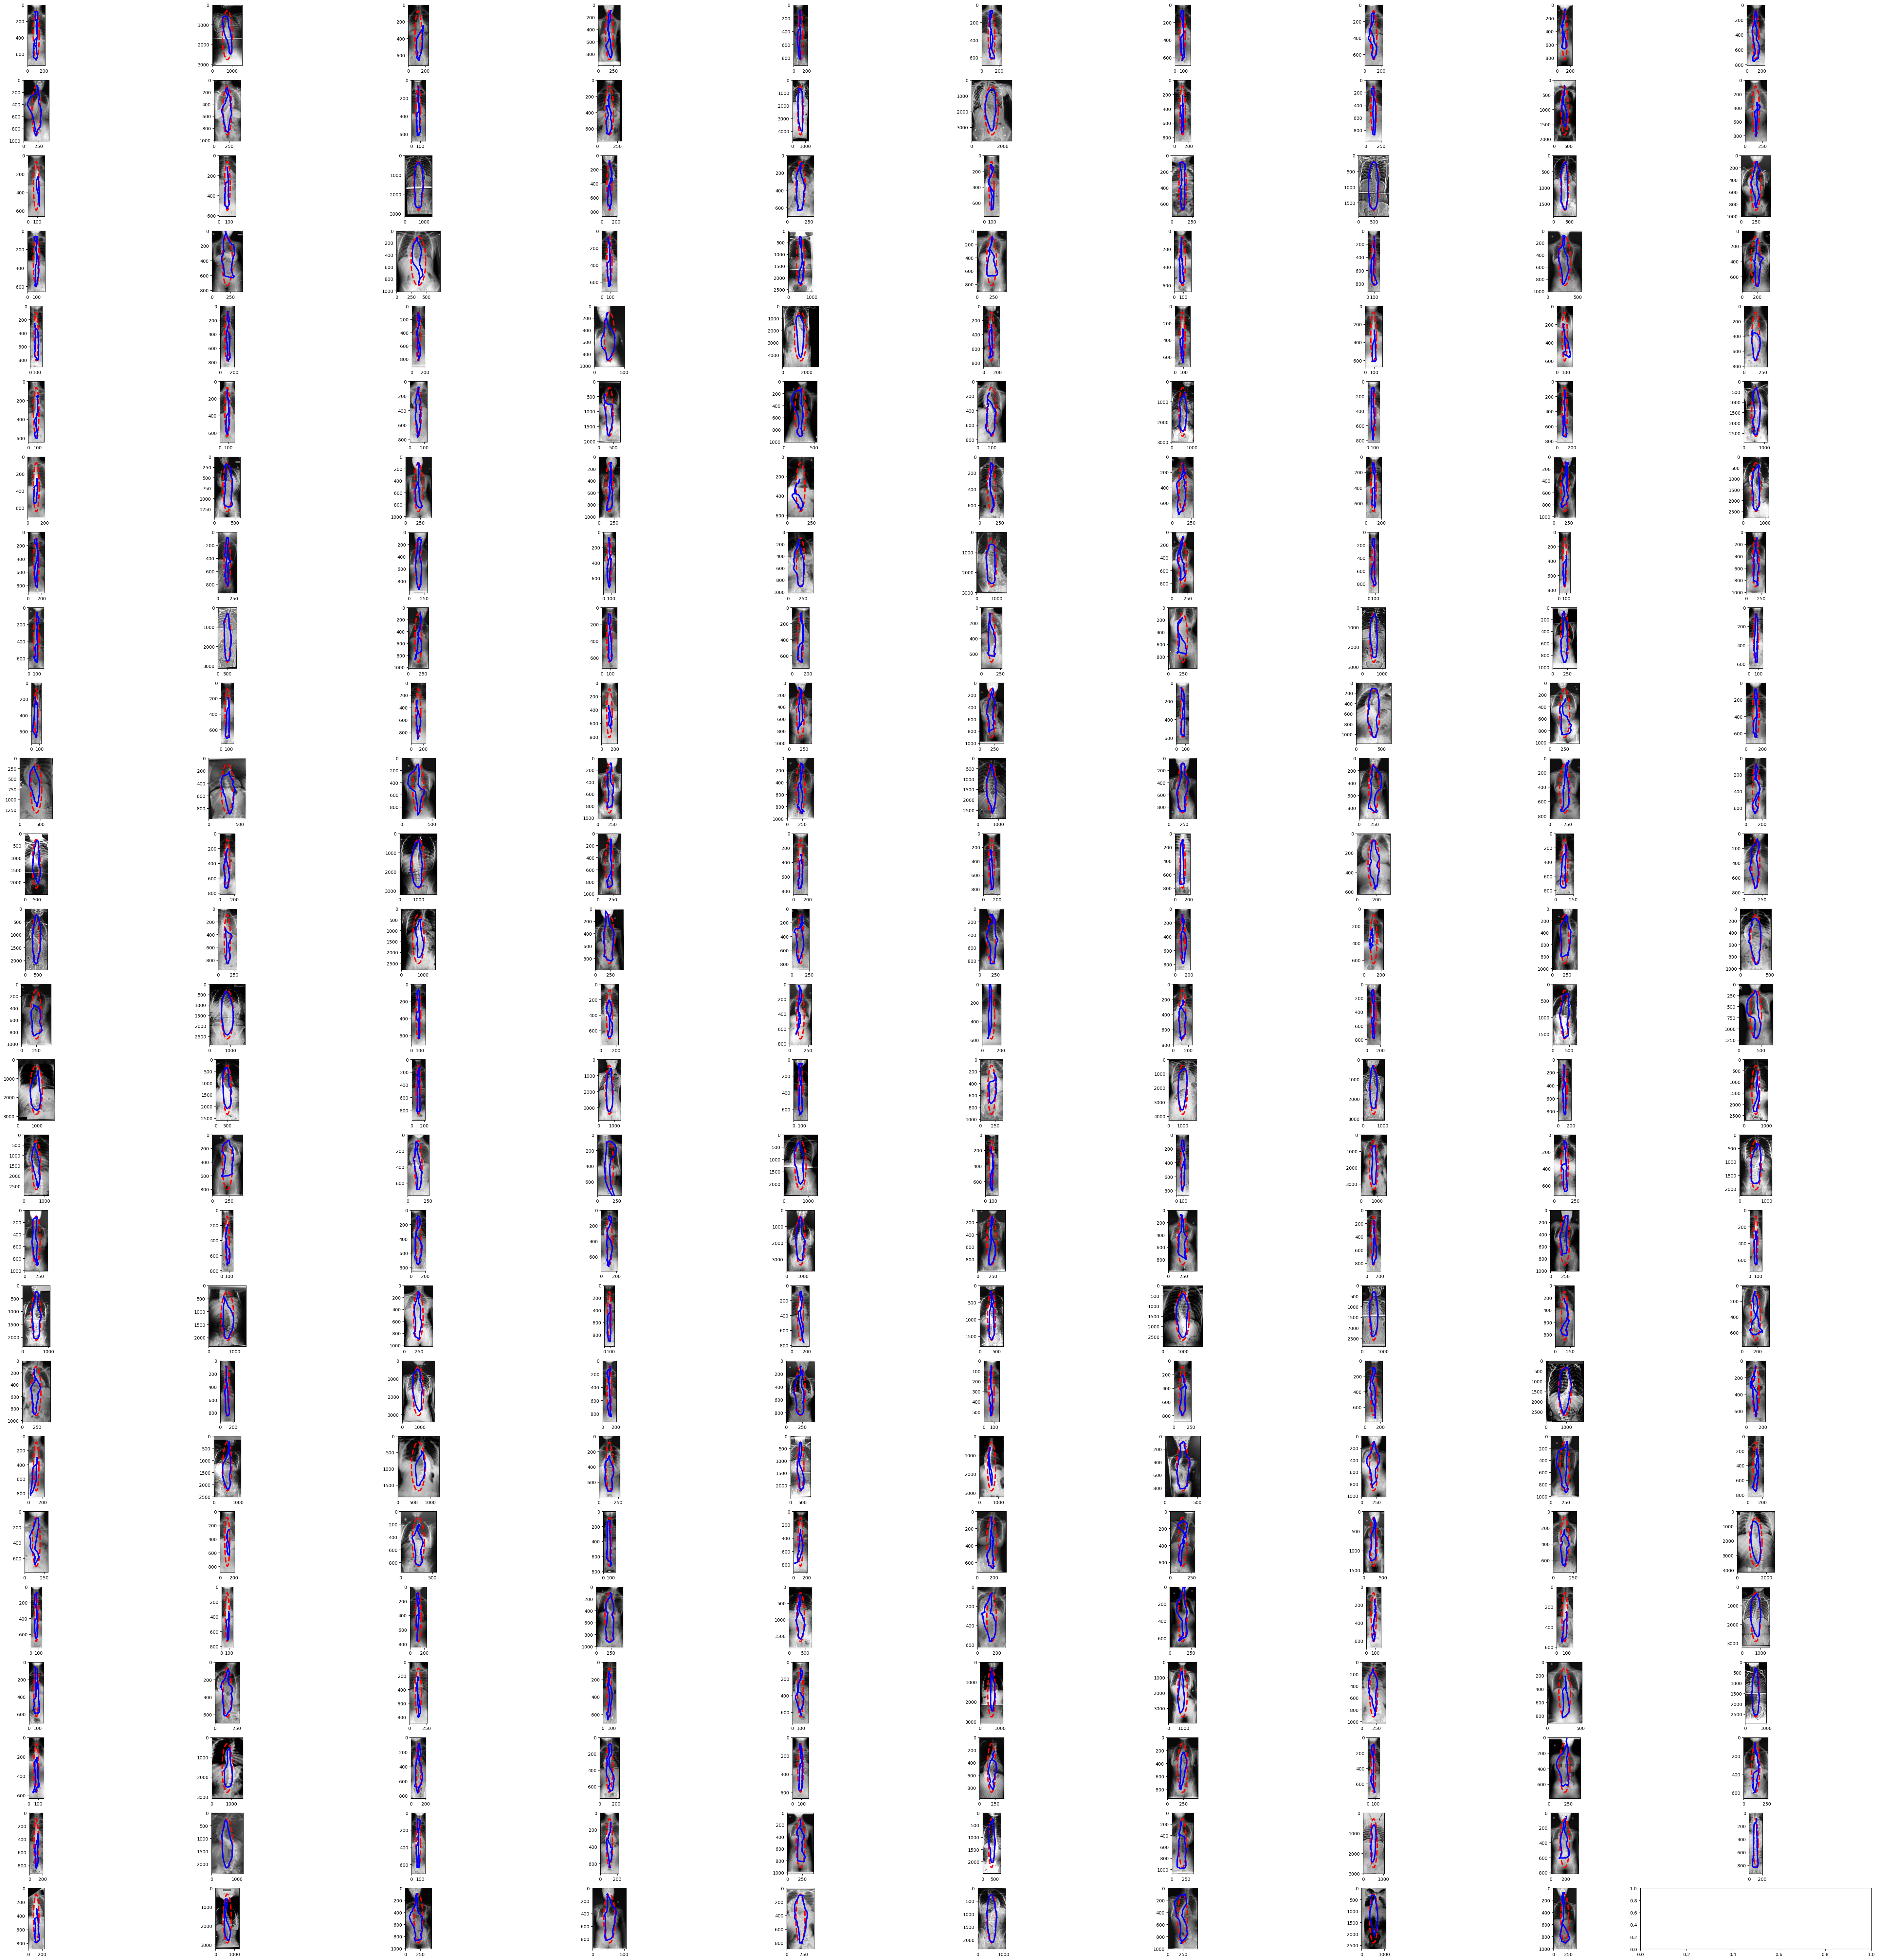

In [123]:
alpha = 0.015 # 0.05
beta = 0.01 #1
gamma = 0.00001 #0.001 
num_iterations = 300 #1000
wline = -0.5 # #1, positive - attraction to bright spots, negative - repels from bright spots
wedge = 0 
# Get a list of all files in the folder
#Gotta find the best result for scioliosis and hope it works for normal. 
mu = 0.5
gvf_iter = 300
delta = 1

rows = 26 #10,8
cols = 10
fig, ax = plt.subplots(rows, cols, figsize=(60, 60))
ax = ax.flatten()
df = pd.DataFrame()
for i, file in enumerate(image_files):
    image_path = os.path.join(alldict, file) 
    #image_path = os.path.join(scoliosis, file)
    img = cv2.imread(image_path)# Close the image window
    img = rgb2gray(img)
    img = img_as_float(img) 
    img = gaussian(img, 3, preserve_range=False)
    img_matrix = np.array(img)
    #print(img_matrix.shape)
    #print(highest_mean_column_index)
    s = np.linspace(0, 2*np.pi, 1000)
    norm1 = (img_matrix.shape[0])//2 
    norm2 = (img_matrix.shape[1])//2 
    r =  (norm1 - norm1//5)*np.sin(s) + norm1
    c =  (norm2 - (2*norm2)//3)*np.cos(s) + norm2 #norm2 norm2//2 - 10 for normal had best results
    init = np.array([r, c]).T
    final = snake(img, init, alpha, beta, gamma, wline, wedge, num_iterations, 'snake', mu, gvf_iter, delta, 0.01)
    ax[i].imshow(img, cmap=plt.cm.gray)
    ax[i].plot(init[:, 1], init[:, 0], '--r', lw=3, label = 'Initalization')
    ax[i].plot(final[:, 1], final[:, 0], '-b', lw=3, label = 'Snake')
    ax[i].axis([0, img.shape[1], img.shape[0], 0])
    mydict = snake_metrics(final, init, img_matrix, 16)
    if ',N,' in file:
        mydict['Target'] = 0 #Normal
    else: 
        mydict['Target'] = 1 #Scoliosis 
    gender = extract_gender(file)
    if gender == 'F':
        mydict['Sex'] = 1 #Female
    else: 
        mydict['Sex'] = 0 #male
    mydict['Age'] = extract_age(file)
    # Concatenate the new row with the existing DataFrame
    new_row = pd.DataFrame([mydict])
    df = pd.concat([df, new_row], ignore_index=True)

plt.tight_layout()
plt.show()

In [175]:
df = df.fillna(0)
y = df['Target'].values
X = df.drop(columns = ['Target','Sex','Age']).values 
#plit that into train and test#
#Run various different classifers to see if its possible based on the outputed metrics
df
#See if degree is possible 


1/16 tangent  1/16 distance  2/16 tangent  2/16 distance  3/16 tangent  \
0       -1.386107      -0.162135      1.532229      -0.092365      1.497243   
1        1.444409      -0.019307      1.458287       0.035136      1.559488   
2       -1.565118       0.029448     -1.564588      -0.076135     -1.506918   
3        1.374884      -0.086923      1.426042      -0.010873      1.493174   
4       -1.523388      -0.186765     -1.546219      -0.161337     -1.568335   
..            ...            ...           ...            ...           ...   
254     -1.462683       0.046168     -1.445573       0.013932     -1.375279   
255     -1.460340       0.005223     -1.509109       0.019753     -1.509283   
256      1.240134      -0.022121      1.461919       0.020534      1.493714   
257      1.434856       0.004046      1.503642       0.048378      1.519740   
258      1.419682      -0.212879      1.391722       0.063331     -1.505450   

     3/16 distance  4/16 tangent  4/16 distance  5/16 tangent  5/16 distance  \
0        -0.035382      1.490157       0.001740      1.378897       0.000473   
1         0.085382      1.560681       0.104110      1.329924       0.120892   
2        -0.029302     -1.431338       0.034173     -1.289966       0.047736   
3         0.010280      1.530349       0.076060      0.408187       0.097965   
4        -0.090047      1.541201      -0.038877      1.566948       0.042654   
..             ...           ...            ...           ...            ...   
254      -0.002137     -1.164318       0.059553      1.098232       0.030442   
255       0.027830     -1.383486       0.011932      0.938643      -0.008057   
256      -0.046359     -1.061410      -0.036963      0.746224       0.024640   
257       0.110286      1.532272       0.127101     -0.953275       0.043700   
258       0.031574     -1.483695       0.021272      1.107237      -0.053321   

     ...  13/16 distance  14/16 tangent  14/16 distance  15/16 tangent  \
0    ...        0.053790       1.542906        0.077960       1.546922   
1    ...        0.223911       1.319406        0.202180       1.237604   
2    ...        0.257202      -1.524171        0.172779      -1.502972   
3    ...       -0.026048      -1.537086       -0.076426       1.535760   
4    ...        0.082129      -1.570669        0.168713      -1.561337   
..   ...             ...            ...             ...            ...   
254  ...        0.011224       1.286574        0.009006       1.532472   
255  ...        0.004410       1.408640        0.035751       1.436204   
256  ...        0.003894       1.567903        0.046649       1.477888   
257  ...        0.034611       1.436411       -0.005475       1.438338   
258  ...       -0.047761      -1.557727       -0.083528      -1.534921   

     15/16 distance  16/16 tangent  16/16 distance  Target  Sex  Age  
0          0.072981       1.550853        0.026570       0    1    0  
1          0.126952       0.989211        0.036500       1    1   12  
2          0.048228      -1.463397       -0.060734       1    1   12  
3          0.028655       1.526259       -0.011188       1    1   13  
4          0.064348       1.466409       -0.086062       0    1    0  
..              ...            ...             ...     ...  ...  ...  
254        0.005823       1.535645        0.001792       1    0   12  
255        0.018284       1.435579       -0.017520       1    1   14  
256        0.039663       1.371148        0.016204       1    1   12  
257       -0.083784       1.355117       -0.169768       1    1   13  
258        0.033155      -1.526008        0.021895       1    0   16  

[259 rows x 35 columns]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42, stratify =y)


#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#Train the test set and stratify for best results
#X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state = 42, stratify =y)

              precision    recall  f1-score   support

      Normal      1.000     0.143     0.250        14
   Scoliosis      0.760     1.000     0.864        38

    accuracy                          0.769        52
   macro avg      0.880     0.571     0.557        52
weighted avg      0.825     0.769     0.698        52



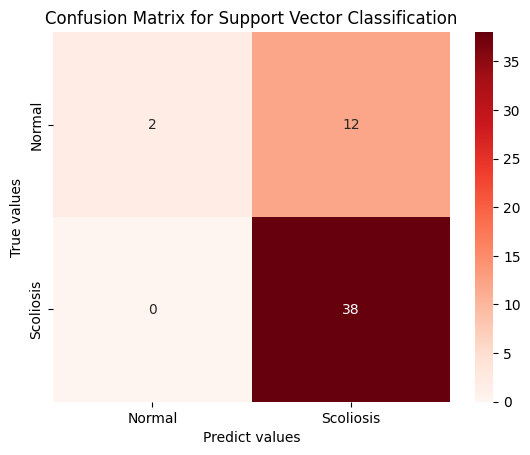

In [178]:
#SVM IS PRELIMINARY CLASSIFIER
target_names = ['Normal', 'Scoliosis']
clf = svm.SVC()
clf.fit(X_train,y_train) #Fit the model
test_prediction2 = clf.predict(X_test)
print(metrics.classification_report(y_test, test_prediction2, digits=3, target_names=target_names))
# Confusion matrix
conf_matrix2 = metrics.confusion_matrix(y_test, test_prediction2)
Confusion2 = pd.DataFrame(conf_matrix2, index = target_names, columns = target_names)
sns.heatmap(conf_matrix2, annot = True, cmap='Reds', xticklabels= target_names, yticklabels= target_names)
plt.xlabel('Predict values')
plt.ylabel('True values')
plt.title('Confusion Matrix for Support Vector Classification')

plt.show()

In [179]:
skb = SelectKBest(f_classif, k=5)
X_new = skb.fit_transform(X, y)
indices = skb.get_support(indices = True)
for i in indices: 
    print(df.columns[i])

1/16 distance
4/16 tangent
5/16 distance
10/16 tangent
11/16 tangent


In [ ]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print(metrics.classification_report(y_test, y_pred, digits=3, target_names=target_names))

# Confusion matrix
conf_matrix3 = metrics.confusion_matrix(y_test, y_pred)
Confusion3 = pd.DataFrame(conf_matrix3, index = target_names, columns = target_names)
sns.heatmap(conf_matrix3, annot = True, cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predict values')
plt.ylabel('True values')
plt.title('Confusion Matrix for Gaussian naive bayes')

plt.show()

              precision    recall  f1-score   support

      Normal      0.583     0.500     0.538        14
   Scoliosis      0.825     0.868     0.846        38

    accuracy                          0.769        52
   macro avg      0.704     0.684     0.692        52
weighted avg      0.760     0.769     0.763        52



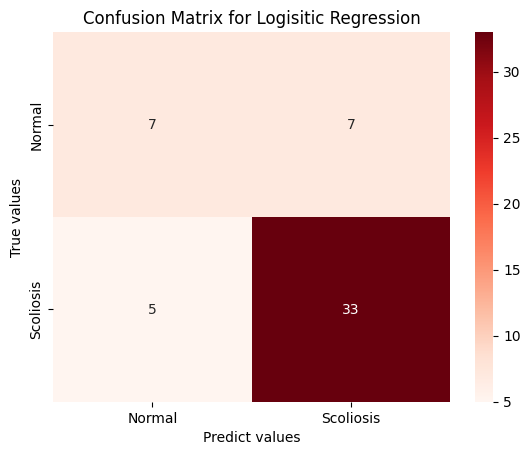

In [180]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train) #Fit the model
test_prediction = log_reg.predict(X_test)
y_pred = log_reg.predict_proba(X_test)[:,1]
print(metrics.classification_report(y_test, test_prediction, digits=3, target_names=target_names))
# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, test_prediction)
Confusion = pd.DataFrame(conf_matrix, index = target_names, columns = target_names)
sns.heatmap(conf_matrix, annot = True, cmap='Reds', xticklabels=target_names, yticklabels= target_names)
plt.xlabel('Predict values')
plt.ylabel('True values')
plt.title('Confusion Matrix for Logisitic Regression')

plt.show()

In [ ]:
tre = tree.DecisionTreeClassifier()
tre.fit(X_train, y_train)
tre_pred = tre.predict(X_test)
print(metrics.classification_report(y_test, tre_pred, digits=3, target_names=target_names))

# Confusion matrix
conf_matrix4 = metrics.confusion_matrix(y_test, tre_pred)
Confusion4 = pd.DataFrame(conf_matrix4, index = target_names, columns = target_names)
sns.heatmap(conf_matrix4, annot = True, cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predict values')
plt.ylabel('True values')
plt.title('Confusion Matrix for Decision Tree')

plt.show()